# Anysee Tutorial 03 - Face Recognition album pipeline

In this example we will first show how to use the Face Compare API to find all images of yourself in an album.
<img src="https://github.com/japancv/JCV-Cloud-Face-Recognition/blob/main/examples/03_%20Face_Recognition_example/compared_1.jpg?raw=true" alt="sample" width="400"/>

For this example, We need a JCV Cloud API key. Get one from the JCV Cloud page or refer to this [step-by-step guide](https://github.com/japancv/JCV-Cloud-Face-Recognition/blob/main/docs/QuickStart_Anysee.md) to obtain a free-to-use JCV Cloud API key in 5 minutes.

In this example, we will use the compare function to find where your face is in the image. There are two ways to do this, either using the advanced API of face searching, or using the basic API of face comparing. 

In this example we will be using the compare API.

The workflow will look like this, note that the compare API compares the *largest* face in the image, thus we need to crop out the faces before sending them to the server:

1. detect all faces
2. Compare the detected faces with one face
3. mark all faces that has high similarity with the onne face you are looking for

Let's start by downloading the images needed to create the example album. I have a small album of G7 images ready to download, let's try to find where the Japanese prime minister Fumio Kishida is.

In [9]:
import cv2
import base64
import requests
from matplotlib import pyplot as plt
from requests.structures import CaseInsensitiveDict

album = [
    'https://d3i6fh83elv35t.cloudfront.net/static/2023/03/2023-03-21T171058Z_502109839_RC2FYZ99EXCD_RTRMADP_3_UKRAINE-CRISIS-JAPAN-ZELENSKIY-1024x683.jpg',
    'https://storage.googleapis.com/www-cw-com-tw/article/202305/article-646c8bb06d8ea.jpg',
    'https://newsatcl-pctr.c.yimg.jp/t/amd-img/20230601-01244718-jspa-000-1-view.jpg?exp=10800',
    'https://static.ctwant.com/images/cover/38/142438/md-64888424ab3c57c32668decc14e8ce58.jpg',
    'https://images.chinatimes.com/newsphoto/2023-06-28/1024/B11A00_P_04_02.jpg'
]

for i in range(len(album)):
    img_data = requests.get(album[i]).content
    with open(f'{i}.jpg', 'wb') as handler:
        handler.write(img_data)

Setup our endpoints and urls

In [20]:

region = 'ap-northeast-1' # choose the same region with what we picked when creating the instance
detect_endpoint = 'api/v1/entities/faces/detect'
compare_endpoint = 'api/v1/entities/faces/compare'

detect_url = f'https://anysee.{region}.cloud.japancv.co.jp/{detect_endpoint}'
compare_url = f'https://anysee.{region}.cloud.japancv.co.jp/{compare_endpoint}'

apikey = 'your-apikey'
headers = CaseInsensitiveDict()
headers['Content-Type'] = 'application/json'
headers['api-key'] = apikey

Here we have the REST request body for doing the detection and the comparison. See the [docs](https://docs.cloud.japancv.co.jp/docs/anysee-introduction) for more information. 

For the parameters, img is the image in base64 format.
Return detatils imply whether we want the following details to be returned. Keep `pos` true and other flase for now.
`pos` stands for the position, `ang` stands for angle, `lnd` stands for landmark locations, `qua` stands for the quality of the face, and `att` stands for the attributes.

This should be similar to the [face detection example](../01_Face_detection_example/face_detection.ipynb)

The Json body for comparison will look like this:
```
{
    // Two different models available: JCV_FACE_K25000 or JCV_FACE_J10000
    "model": "JCV_FACE_K25000", 
    "imageOne": {
        "data": "BASE64_ENCODED_IMAGE", // Image to detect in base64 encoding
        "area": {               // Area of interest
            "top": 0,
            "left": 0,
            "width": 1000,
            "height": 1000
        },
        "autoRotate": true,     // automatically checks four orientations of the image
        "returnDetails": {      // Whether to return the following details
            "position": true,
            "angle": true,
            "landmarks": true,
            "quality": true,
            "attributes": true
        }
    },
    "imageTwo": {
        "data": "BASE64_ENCODED_IMAGE", // Image to detect in base64 encoding
        "area": {               // Area of interest
            "top": 0,
            "left": 0,
            "width": 1000,
            "height": 1000
        },
        "autoRotate": true,     // automatically checks four orientations of the image
        "returnDetails": {      // Whether to return the following details
            "position": true,
            "angle": true,
            "landmarks": true,
            "quality": true,
            "attributes": true
        }
    }
}
```


In [57]:
def sendDetectionRequest(img:str, pos=False, ang=False, lnd=False, qua=False, att=False):
    data = {}
    image = {}
    rd = {}
    rd["position"] = pos
    rd["angle"] = ang
    rd["landmarks"] = lnd
    rd["quality"] = qua
    rd["attributes"] = att
    image['data'] = img
    image['autoRotate'] = True
    image['returnDetails'] = rd
    data['model'] = 'JCV_FACE_K25000'
    data['image'] = image
    success = True
    try:
        res = requests.post(detect_url, json=data, headers=headers, timeout=10)
    except Exception as e:
        res = f'Anysee endpoint timeout: {e}'
        success = False
    if res == 'Anysee endpoint timeout' or res.status_code != 200:
        success = False
    return res, success

def sendCompareRequest(img:str, img2:str, pos=False, ang=False, lnd=False, qua=False, att=False, img2area={}):
    data = {}
    image = {}
    rd = {}
    rd["position"] = pos
    rd["angle"] = ang
    rd["landmarks"] = lnd
    rd["quality"] = qua
    rd["attributes"] = att
    image['data'] = img
    image['autoRotate'] = True
    image['returnDetails'] = rd
    data['model'] = 'JCV_FACE_K25000'
    data['imageOne'] = image

    image2 = {}
    image2['data'] = img2
    image2['area'] = img2area
    data['imageTwo'] = image2
    success = True
    try:
        res = requests.post(compare_url, json=data, headers=headers, timeout=10)
    except Exception as e:
        res = f'Anysee endpoint timeout: {e}'
        success = False
    if res == 'Anysee endpoint timeout' or res.status_code != 200:
        success = False
    return res, success

The API requires a base64 format of the image data, so let's make a function to convert the data to base64 format.

In [58]:
def b64(image_path):
    with open(image_path, "rb") as image_file:
        encode = base64.b64encode(image_file.read()).decode('utf-8')
    return encode

We are going to download an image of the target we are searching from the internet and save it for the demo. 

<img src="https://github.com/japancv/JCV-Cloud-Face-Recognition/blob/main/examples/01_Face_detection_example/sample.jpg?raw=true" alt="sample" width="200"/>

In [59]:
img_data = requests.get('https://img.kyodonews.net/english/public/images/posts/ed58f81ded6f4ac7f66e61fed97fbe39/photo_l.jpg').content
with open('sample.jpg', 'wb') as handler:
    handler.write(img_data)

Write a draw function for verifying the results 

In [60]:
def draw_img(imgpth, pos):
    img = cv2.imread(imgpth) # read the image in
    img = cv2.rectangle(img, (pos['left'], pos['top']), (pos['left'] + pos['width'], pos['top'] + pos['height']), (255,0,0), 2)    
    cv2.imwrite('compared_'+imgpth, img)
    return img

Now that we have the example image that we need, let's start doing some face detection!

Loop through the images we download as the photo album. You can change to your local album too. 

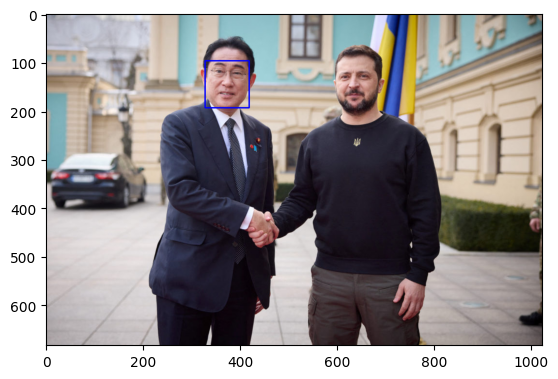

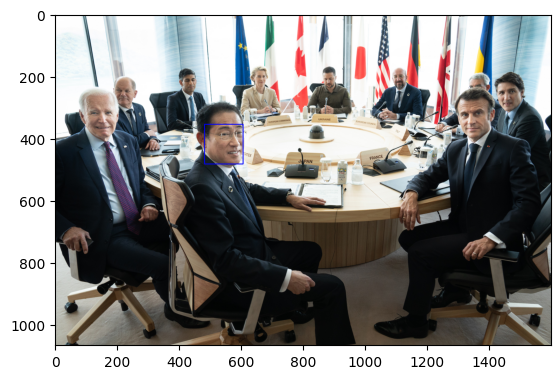

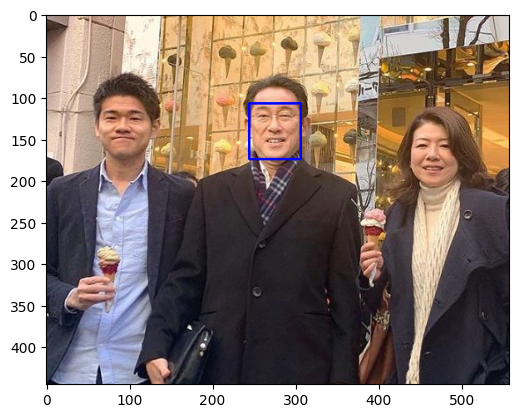

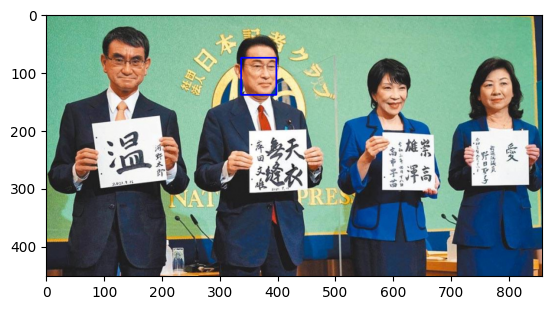

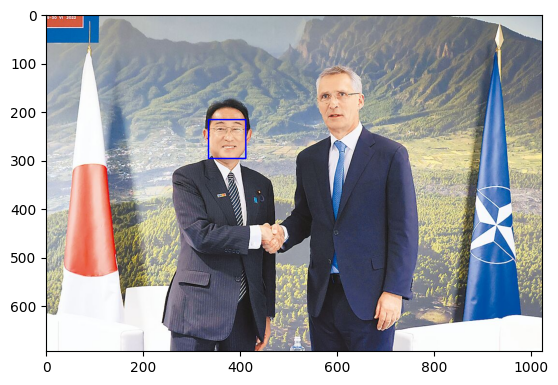

In [61]:
for i in range(5):
    path = f'{i}.jpg'
    req_img = b64(path)
    sample_img = b64('sample.jpg')
    res, suc = sendDetectionRequest(req_img, pos=True, ang=False, lnd=False, qua=False, att=False)
    if suc:
        obj = res.json()
        num_face_detected = obj['count']
        faces_detected = obj['entities']
        face_details = [face['details'] for face in faces_detected]
        positions = [face['position'] for face in face_details]
        for i in range(len(faces_detected)):
            res2, suc2 = sendCompareRequest(sample_img, req_img, img2area=positions[i])
            if suc2 and res2.json()['similarityScore']> 0.9:
                outcome = draw_img(path, positions[i])
                outcome = outcome[:,:,::-1] # transform image from BGR to RGB
                plt.imshow(outcome)
                plt.show()


Protip: If you want to search for multiple identites (say you want to find all your classmates in a field day album), you can use the [search faces](https://docs.cloud.japancv.co.jp/reference/anysee-search-entity) funtion or the [identity manger](https://docs.cloud.japancv.co.jp/reference/id-create-identity) function of JCV Cloud. Check out the [Face quality register search example](../02_Face_quality_register_search_example/face_quality_register_search.ipynb)